# Neural Networks

In [475]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

In [2]:
samples, targets = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [3]:
# Normalization
samples = samples / 255.

In [248]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])


def sigmoid(x):
    return 1. / (1. + np.exp(-x))


def sigmoid_grad(out, grad_in):
    return out * (1 - out) * grad_in


def softmax(x):
    num = np.exp(x - np.max(x))
    
    return num / np.sum(num, axis=0, keepdims=True)


# def softmax_grad(out, grad_in):
#       return (np.einsum('ij,jk->ijk', out, np.eye(out.shape[-1])) \
#            - np.einsum('ij,ik->ijk', out, out))
    
    
def softmax_grad(probs, bp_err):
    dim = probs.shape[1]
    output = np.empty(probs.shape)
    for j in range(dim):
        d_prob_over_xj = - (probs * probs[:,[j]])  # i.e. prob_k * prob_j, no matter k==j or not
        d_prob_over_xj[:,j] += probs[:,j]   # i.e. when k==j, +prob_j
        output[:,j] = np.sum(bp_err * d_prob_over_xj, axis=1)
    return output


def cross_entropy_loss(pred, target):
    return -target * np.log(pred)


def cross_entropy_grad(pred, target):
    return target - pred

In [494]:
num_features = samples.shape[1]
num_classes = 10

# Output layer configuration
layer1_weights = (np.random.rand(num_classes, num_features + 1) - 0.5)

# Forward Pass

In [495]:
layer1_a = layer1_weights @ np.concatenate((np.ones((samples.shape[0], 1)), samples), axis=1).T
layer1_z = softmax(layer1_a)

In [496]:
loss = cross_entropy_loss(layer1_z.T, get_one_hot(targets.astype(int), 10))

In [497]:
print(np.sum(np.mean(loss, axis=0)))

4.428888817314736


# Backward Pass

In [465]:
d_loss = cross_entropy_grad(layer1_z.T, get_one_hot(targets.astype(int), 10))
d_layer1_z = softmax_grad(layer1_z.T, d_loss)
d_layer1_weights = d_layer1_z.T @ np.concatenate((np.ones((samples.shape[0], 1)), samples), axis=1)

In [526]:
batch_size = 32
losses = []
correct = 0
lr = 0.001

for batch_idx in range(0, samples.shape[0], batch_size):
    start_idx = batch_idx
    end_idx = start_idx + batch_size if start_idx + batch_size < samples.shape[0] else samples.shape[0]
    batch_samples = samples[start_idx : end_idx]
    batch_targets = get_one_hot(targets[start_idx : end_idx].astype(int), 10)
    
    # Forward Pass
    layer1_a = layer1_weights @ np.concatenate((np.ones((batch_samples.shape[0], 1)), batch_samples), axis=1).T
    layer1_z = softmax(layer1_a)
    
    loss = cross_entropy_loss(layer1_z.T, batch_targets)
    
    loss = np.sum(np.mean(loss, axis=0))
    losses.append(loss)
    
    correct += np.sum(np.argmax(layer1_z, axis=0) == targets[start_idx : end_idx].astype(int))

    # Backward Pass
    d_loss = cross_entropy_grad(layer1_z.T, batch_targets)
    d_layer1_z = softmax_grad(layer1_z.T, d_loss)
    d_layer1_weights = d_layer1_z.T @ np.concatenate((np.ones((batch_samples.shape[0], 1)), batch_samples), axis=1)
    
    # Gradient step
    layer1_weights = layer1_weights + lr * d_layer1_weights

In [527]:
print(correct / samples.shape[0])

0.905


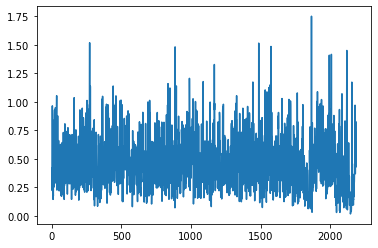

In [493]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(losses)